In [48]:
# third Question
# first we wanna create all our utilities ...
# lets go


# headers & imports
import math
import torch
import numpy as np
import random
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from scipy import signal


# utilities ...

# sin wave
def sinWave(amp, signal_period, signal_size):
    a = amp * np.sin(np.arange(signal_size) * (2 * np.pi / signal_period))
    return a


# Triangle wave
def triangleWave(amp, signal_period, signal_size):
       return signal.triang(signal_size)
    
    # Note:Another implementation ...
        #
        # we can also recreate triangle wave via creativity ...
        #
        #    u_period = np.linspace(-amplitude, amplitude, signal_period)
        #    l_period = np.linspace(amplitude, -amplitude, signal_period)
        #    a = np.concatenate([u_period[1:], l_period[1:]] * int(signal_size/signal_period), 0)
        #    return a[:signal_size]
        #
    
# Teeth wave
def teethWave(amplitude, signal_period, signal_size):
    f_period = np.linspace(-amplitude, amplitude, signal_period)
    a = np.concatenate([f_period] * int(2 * signal_size/signal_period), 0)
    return a[:signal_size] #signal.sawtooth(2 * np.pi * 5 * signal_size)


# create noisy!Signal ...
def noiseSignal(inputSignal_gonna_have_noise, mode,mean,var):
    
    if mode == 'uniform':
        noise = np.random.uniform(mean,var, size=inputSignal_gonna_have_noise.shape)
    elif mode == 'normal':
        noise = np.random.normal(mean,var, size=inputSignal_gonna_have_noise.shape)
        
    # create new output Matrix with the same matrix size as input signal ...    
    brownian = np.zeros(inputSignal_gonna_have_noise.shape)

    # casuality!!!
    brownian[0] = noise[0]
    
    # finding the integral of noise ...
    for i in range(1, int(inputSignal_gonna_have_noise.shape[0])):
        # as we know brownian signal is integral of noise signal
        # so as we read in discrete forms we know that
        # y[n] - y[n-1] is equal to derivative of the signal
        # we know that the brownian signal is integral of noise of signal so its derviative is equal to the noise signal
        # so we have the equation : 
        # brownian[n] - brownian[n-1] = noise[n] --> brownian[n] = brownian[n-1] + noise[n]
        # we considered the initial point of brownian[n] as zero ... (casuality ...)
        # so U see the equation below ...
        brownian[i] = noise[i] + brownian[i-1]
    # return     
    return inputSignal_gonna_have_noise + noise, inputSignal_gonna_have_noise + brownian


# Test data of sin wave
def sineSample(amplitude, signal_period, sample_size, mode,mean,var):
    
    # random_offset = random.randint(0, sample_size)
    random_offset = 0
    # X = np.arange(sample_size)
    # out = sine(X + random_offset, signal_period)
    out = sinWave(amplitude, signal_period, sample_size)
    inp1, inp2 = noiseSignal(out, 'normal',mean,var)
    
    if mode == 'brownian':
        return inp2, out
    else:
        return inp1, out


# Test data of triangle wave
def triangleSample(amplitude, signal_period, sample_size, mode,mean,var):
    
    # random_offset = random.randint(0, sample_size)
    random_offset = 0
    # X = np.arange(sample_size)
    # out = sine(X + random_offset, signal_period)
    out = triangleWave(amplitude, signal_period, sample_size)
    inp1, inp2 = noiseSignal(out, 'normal',mean ,var)
    
    if mode == 'brownian':
        return inp2, out
    else:
        return inp1, out


# Test data of tooth wave
def teethSample(amplitude, signal_period, sample_size, mode,mean,var):
    
    # random_offset = random.randint(0, sample_size)
    random_offset = 0
    # X = np.arange(sample_size)
    # out = sine(X + random_offset, signal_period)
    out = teethWave(amplitude, signal_period, sample_size)
    inp1, inp2 = noiseSignal(out, 'normal',mean,var)
    
    if mode == 'brownian':
        return inp2, out
    else:
        return inp1, out


# Overall dataset creation for nets
def createDataset(n_samples,amplitude, signal_period, sample_size, mode, noise_mode,mean,var):
    data_inp = np.zeros((n_samples, sample_size))
    data_out = np.zeros((n_samples, sample_size))
    
    if mode == 'sin':
        for i in range(n_samples):
            sample_inp, sample_out = sineSample(amplitude, signal_period, sample_size, noise_mode,mean,var) # Also can be brownian
            data_inp[i, :] = sample_inp
            data_out[i, :] = sample_out
            
    elif mode == 'triangle':
        for i in range(n_samples):
            sample_inp, sample_out = triangleSample(amplitude, signal_period, sample_size, noise_mode,mean,var)
            data_inp[i, :] = sample_inp
            data_out[i, :] = sample_out
            
    elif mode == 'teeth':
        for i in range(n_samples):
            sample_inp, sample_out = teethSample(amplitude, signal_period, sample_size, noise_mode,mean,var)
            data_inp[i, :] = sample_inp
            data_out[i, :] = sample_out
            
    return data_inp, data_out


# Vriantic dataset creation for nets
def variantic_dataset_sine(n_samples,amplitude, signal_period, sample_size, mode, noise_mode,mean, variance):
    data_inp = np.zeros((n_samples, sample_size))
    data_out = np.zeros((n_samples, sample_size))
    
    for i in range(n_samples):
        sample_inp, sample_out = sineSample(amplitude, signal_period, sample_size, noise_mode,mean,variance)# Also can be brownian
        data_inp[i, :] = sample_inp
        data_out[i, :] = sample_out
    return data_inp, data_out


class DenoiseRNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(DenoiseRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        self.act = nn.Tanh()

    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred


losses!!! [0.62716931 0.54593682 0.46008316 0.34408411 0.16058584 0.18877684
 0.22500904 0.18012106 0.10931297 0.10496158 0.13580893 0.13397221
 0.10513467 0.08770575 0.0972746  0.11054301 0.11116194 0.10243048
 0.09299409 0.08725863 0.09106053 0.09851079 0.09779009 0.09117968
 0.08675958 0.08685245 0.08944507 0.09183535 0.09107714 0.08772677]
tensor(0.0855, grad_fn=<L1LossBackward>)


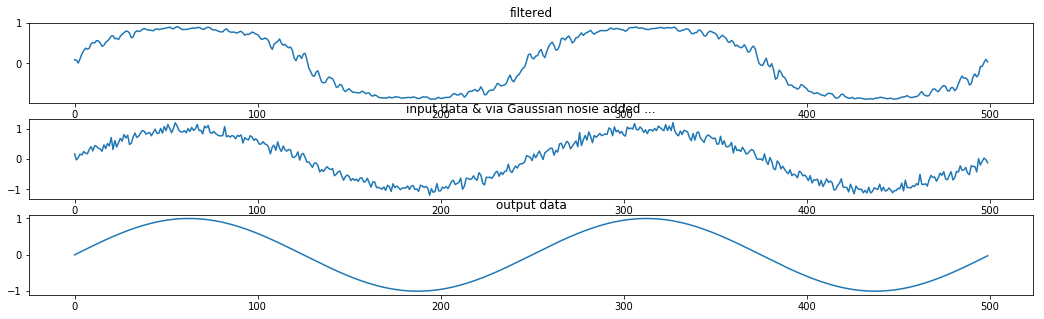

Text(0,0.5,'sinValue')

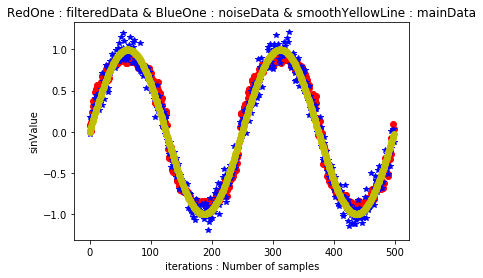

In [10]:
"""
Sinus Wave
1.Creating Noisy signal --> now it is gaussian
2.Creating RNN and filter the noisy Data
3.plot the Graphs and enjoy the accurance of the functions ...
"""
sinInputData, sinOutputData = createDataset(100, 1, 250, 500, 'sin', 'n',0,0.1)
# as TA mentioned we considered 80 percent of input as Train part and left 20 percent as test ...
TrainSinInp, TrainSinOut = sinInputData[:80], sinOutputData[:80]
TestSinInp, TestSinOut = sinInputData[80:], sinOutputData[80:]

input_dim = 1
hidden_size_net = 50
num_layers = 1

sinDenoise = DenoiseRNN(input_dim, hidden_size_net, 1)

predictions = []
optimizer = torch.optim.Adam(sinDenoise.parameters(), lr=6e-3)
loss_func = nn.L1Loss()

iterationNumber = 30
lossDoc = np.zeros(iterationNumber)
for t in range(iterationNumber):
    
    hidden = None
    inp = Variable(torch.Tensor(TrainSinInp.reshape((TrainSinInp.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(TrainSinOut.reshape((TrainSinOut.shape[0], -1, 1))) )
    
    pred = sinDenoise(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    lossDoc[t] = loss
    loss.backward()
    optimizer.step()

print("losses!!!",lossDoc)   

t_inp = Variable(torch.Tensor(TestSinInp.reshape((TestSinInp.shape[0], -1, 1))), requires_grad=True)
pred_t = sinDenoise(t_inp)

# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(TestSinOut.reshape((TestSinInp.shape[0], -1, 1))))))
sample_num = 10

plt.subplot(3, 1, 1)
plt.plot(pred_t[sample_num].data.numpy())
plt.title('filtered')
plt.subplot(3, 1, 2)

plt.plot(t_inp[sample_num].data.numpy())
plt.title('input data & via Gaussian nosie added ...')
plt.subplot(3, 1, 3)
plt.plot(TestSinOut[sample_num])
plt.title('output data')

plt.gcf().set_size_inches(18, 5)
plt.show()

# all togather ...

plt.plot(pred_t[sample_num].data.numpy(),'ro')
plt.plot(t_inp[sample_num].data.numpy(),'b*')
plt.plot(TestSinOut[sample_num],'yo-')

plt.title("RedOne : filteredData & BlueOne : noiseData & smoothYellowLine : mainData")
plt.xlabel("iterations : Number of samples")
plt.ylabel("sinValue")

# as you see the RedOnes are nearer to the main Data ...
# so our filter works properly!!!

losses!!! [0.41306862 0.28424636 0.25691575 0.26045564 0.24116462 0.22181094
 0.21552102 0.2118274  0.19709176 0.17391807 0.15261292 0.12563498
 0.10356268 0.11627041 0.0970495  0.09839445 0.10312606 0.10402349
 0.09848822 0.09383392 0.09251461 0.09358224 0.09501458 0.08935108
 0.08673608 0.08627599 0.08658925 0.08633155 0.08335322 0.08077338]
tensor(0.0617, grad_fn=<L1LossBackward>)


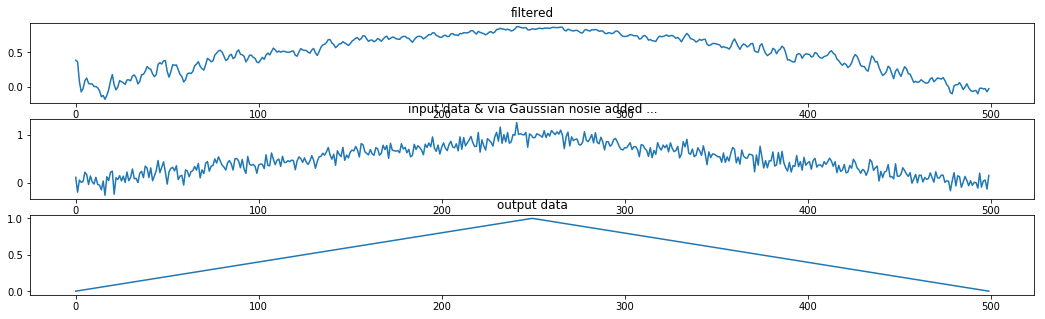

Text(0,0.5,'sinValue')

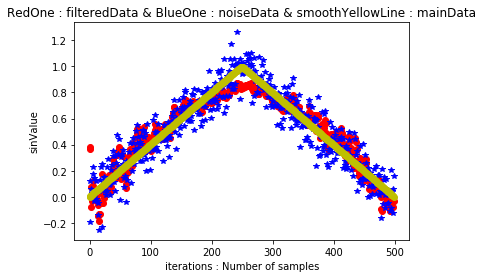

In [11]:
"""
Triangle Wave
1.Creating Noisy signal ---> now it is gaussian
2.Creating RNN and filter the noisy Data
3.plot the Graphs and enjoy the accurance of the functions ...
"""
TriangleInputData, TriangleOutputData = createDataset(100, 1, 250, 500, 'triangle', 'n',0,0.1)
# as TA mentioned we considered 80 percent of input as Train part and left 20 percent as test ...
TrainTriangleInp, TrainTraingleOut = TriangleInputData[:80], TriangleOutputData[:80]
TestTriangleInp, TestTriangleOut = TriangleInputData[80:], TriangleOutputData[80:]

input_dim = 1
hidden_size_net = 50
num_layers = 1

triDenoise = DenoiseRNN(input_dim, hidden_size_net, 1)

predictions = []
optimizer = torch.optim.Adam(triDenoise.parameters(), lr=6e-3)
loss_func = nn.L1Loss()

iterationNumber = 30
lossDoc = np.zeros(iterationNumber)
for t in range(iterationNumber):
    hidden = None
    inp = Variable(torch.Tensor(TriangleInputData.reshape((TriangleInputData.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(TriangleInputData.reshape((TriangleInputData.shape[0], -1, 1))) )
    
    pred = triDenoise(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    lossDoc[t] = loss
    loss.backward()
    optimizer.step()

print("losses!!!",lossDoc)       
t_inp = Variable(torch.Tensor(TriangleInputData.reshape((TriangleInputData.shape[0], -1, 1))), requires_grad=True)
pred_t = triDenoise(t_inp)

# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(TriangleOutputData.reshape((TriangleInputData.shape[0], -1, 1))))))
sample_num = 11

plt.subplot(3,1, 1)
plt.plot(pred_t[sample_num].data.numpy())
plt.title('filtered')
plt.subplot(3,1, 2)

plt.plot(t_inp[sample_num].data.numpy())
plt.title('input data & via Gaussian nosie added ...')
plt.subplot(3,1, 3)
plt.plot(TestTriangleOut[sample_num])
plt.title('output data')

plt.gcf().set_size_inches(18, 5)
plt.show()

# all togather ...
plt.plot(pred_t[sample_num].data.numpy(),'ro')
plt.plot(t_inp[sample_num].data.numpy(),'b*')
plt.plot(TestTriangleOut[sample_num],'yo-')

plt.title("RedOne : filteredData & BlueOne : noiseData & smoothYellowLine : mainData")
plt.xlabel("iterations : Number of samples")
plt.ylabel("sinValue")

# as you see the RedOnes are nearer to the main Data ...
# and they get closer to the yellow 
# and as you can see the noise input variance is too more than the filtered signal ...
# so our filter works properly ...

losses!!! [0.51192504 0.51192504 0.51192504 0.51192504 0.51192504 0.51192504
 0.51192504 0.51192504 0.51192504 0.51192504 0.51192504 0.51192504
 0.51192504 0.51192504 0.51192504 0.51192504 0.51192504 0.51192504
 0.51192504 0.51192504 0.51192504 0.51192504 0.51192504 0.51192504
 0.51192504 0.51192504 0.51192504 0.51192504 0.51192504 0.51192504]
tensor(0.5119, grad_fn=<L1LossBackward>)


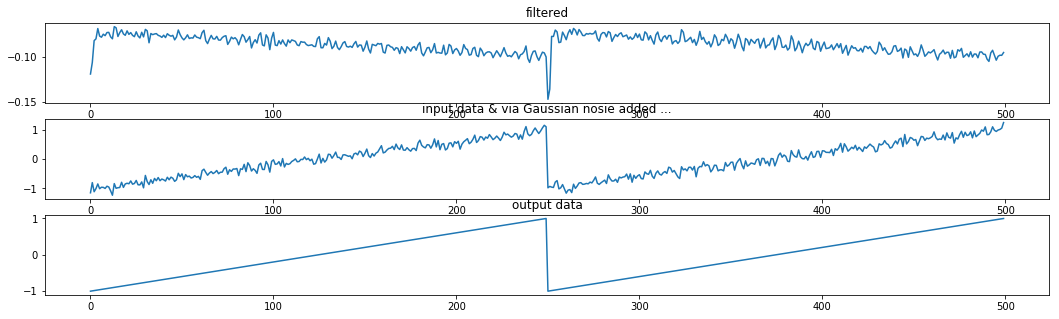

Text(0,0.5,'sinValue')

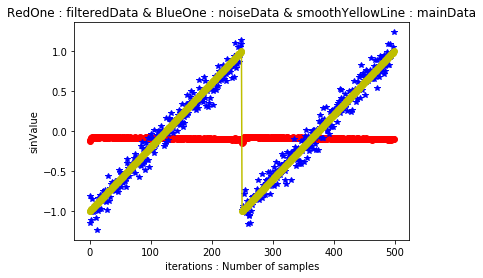

In [37]:
"""
Teeth!!! Wave
1.Creating Noisy signal --> now it is gaussian
2.Creating RNN and filter the noisy Data
3.plot the Graphs and enjoy the accurance of the functions ...
"""
teethInputData, teethOutputData = createDataset(100, 1, 250, 500, 'teeth', 'n',0,0.1)
# as TA mentioned we considered 80 percent of input as Train part and left 20 percent as test ...
TrainTeethInp, TrainTeethOut = teethInputData[:80], teethOutputData[:80]
TestTeethInp, TestTeethOut = teethInputData[80:], teethOutputData[80:]

input_dim = 1
hidden_size_net = 50
num_layers = 1

teethDenoise = DenoiseRNN(input_dim, hidden_size_net, 1)

predictions = []
optimizer = torch.optim.Adam(sinDenoise.parameters(), lr=6e-3)
loss_func = nn.L1Loss()

iterationNumber = 30
lossDoc = np.zeros(iterationNumber)
for t in range(iterationNumber):
    
    hidden = None
    inp = Variable(torch.Tensor(teethInputData.reshape((teethInputData.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(teethOutputData.reshape((teethOutputData.shape[0], -1, 1))) )
    
    pred = teethDenoise(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    lossDoc[t] = loss
    loss.backward()
    optimizer.step()

print("losses!!!",lossDoc)   

t_inp = Variable(torch.Tensor(teethInputData.reshape((teethInputData.shape[0], -1, 1))), requires_grad=True)
pred_t = teethDenoise(t_inp)

# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(teethOutputData.reshape((teethInputData.shape[0], -1, 1))))))
sample_num = 10

plt.subplot(3, 1, 1)
plt.plot(pred_t[sample_num].data.numpy())
plt.title('filtered')
plt.subplot(3, 1, 2)

plt.plot(t_inp[sample_num].data.numpy())
plt.title('input data & via Gaussian nosie added ...')
plt.subplot(3, 1, 3)
plt.plot(TestTeethOut[sample_num])
plt.title('output data')

plt.gcf().set_size_inches(18, 5)
plt.show()

# all togather ...

plt.plot(pred_t[sample_num].data.numpy(),'ro')
plt.plot(t_inp[sample_num].data.numpy(),'b*')
plt.plot(TestTeethOut[sample_num],'yo-')

plt.title("RedOne : filteredData & BlueOne : noiseData & smoothYellowLine : mainData")
plt.xlabel("iterations : Number of samples")
plt.ylabel("sinValue")

# as you see the RedOnes are nearer to the main Data ...
# so our filter works properly!!!

losses!!! [0.65812308 0.5718807  0.52197897 0.50680894 0.51758307 0.52174836
 0.51580375 0.50989485 0.50840843 0.50999832 0.51181126 0.51228726
 0.51144886 0.51001704 0.50852931 0.50730765 0.5068773  0.50744075
 0.50791341 0.50702548 0.50555193 0.50447184 0.50386846 0.50359148
 0.50341237 0.50323093 0.50284857 0.50240427 0.50286579 0.50337619]
tensor(0.6059, grad_fn=<L1LossBackward>)


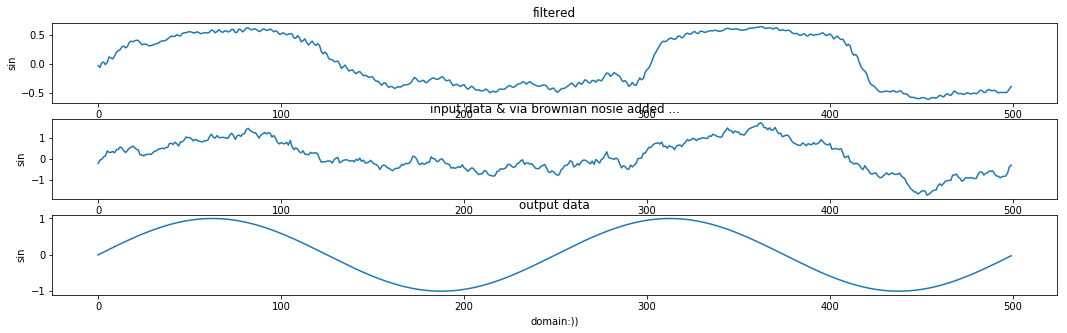

Text(0,0.5,'sinValue')

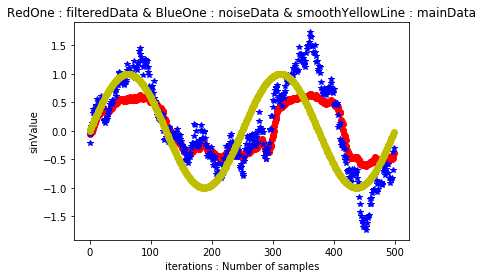

In [39]:
"""
Sinus Wave
1.Creating Noisy signal --> now it is brownian
2.Creating RNN and filter the noisy Data
3.plot the Graphs and enjoy the accurance of the functions ...
"""
sinInputData, sinOutputData = createDataset(100, 1, 250, 500, 'sin', 'brownian',0,0.1)
# as TA mentioned we considered 80 percent of input as Train part and left 20 percent as test ...
TrainSinInp, TrainSinOut = sinInputData[:80], sinOutputData[:80]
TestSinInp, TestSinOut = sinInputData[80:], sinOutputData[80:]

input_dim = 1
hidden_size_net = 50
num_layers = 1

sinDenoise = DenoiseRNN(input_dim, hidden_size_net, 1)

predictions = []
optimizer = torch.optim.Adam(sinDenoise.parameters(), lr=6e-3)
loss_func = nn.L1Loss()

iterationNumber = 30
lossDoc = np.zeros(iterationNumber)
for t in range(iterationNumber):
    
    hidden = None
    inp = Variable(torch.Tensor(TrainSinInp.reshape((TrainSinInp.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(TrainSinOut.reshape((TrainSinOut.shape[0], -1, 1))) )
    
    pred = sinDenoise(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    lossDoc[t] = loss
    loss.backward()
    optimizer.step()

print("losses!!!",lossDoc)   

t_inp = Variable(torch.Tensor(TestSinInp.reshape((TestSinInp.shape[0], -1, 1))), requires_grad=True)
pred_t = sinDenoise(t_inp)

# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(TestSinOut.reshape((TestSinInp.shape[0], -1, 1))))))
sample_num = 10

plt.subplot(3, 1, 1)
plt.plot(pred_t[sample_num].data.numpy())
plt.title('filtered')
plt.ylabel('sin')
plt.xlabel('domain:))')

plt.subplot(3, 1, 2)
plt.plot(t_inp[sample_num].data.numpy())
plt.title('input data & via brownian nosie added ...')
plt.ylabel('sin')
plt.xlabel('domain:))')

plt.subplot(3, 1, 3)
plt.plot(TestSinOut[sample_num])
plt.title('output data')
plt.ylabel('sin')
plt.xlabel('domain:))')

plt.gcf().set_size_inches(18, 5)
plt.show()

# all togather ...

plt.plot(pred_t[sample_num].data.numpy(),'ro')
plt.plot(t_inp[sample_num].data.numpy(),'b*')
plt.plot(TestSinOut[sample_num],'yo-')

plt.title("RedOne : filteredData & BlueOne : noiseData & smoothYellowLine : mainData")
plt.xlabel("iterations : Number of samples")
plt.ylabel("sinValue")

# as you see the RedOnes are nearer to the main Data ...
# so our filter works properly!!!

losses!!! [1.03716588 0.86660337 0.70952034 0.60179228 0.64244431 0.64052033
 0.60350758 0.56936592 0.58578736 0.59737873 0.57867181 0.55950737
 0.56525594 0.57363987 0.57088315 0.56221998 0.55531651 0.55636352
 0.56160194 0.56182986 0.55681121 0.55207545 0.55174708 0.55395955
 0.55507356 0.55365801 0.55073416 0.54850286 0.54851639 0.54982084]
tensor(0.6680, grad_fn=<L1LossBackward>)


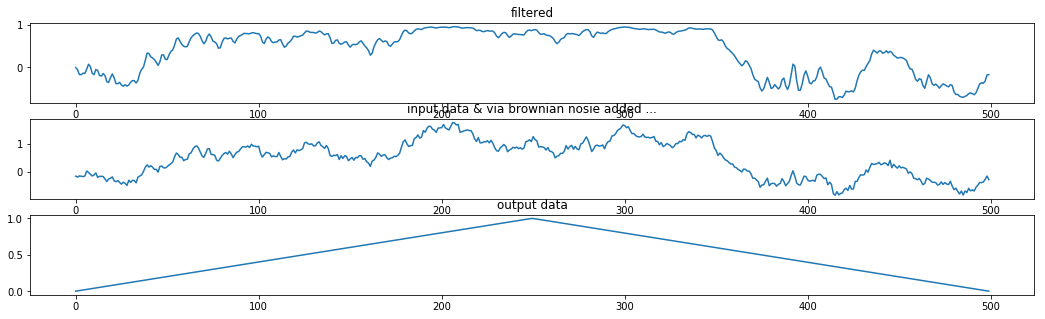

Text(0,0.5,'sinValue')

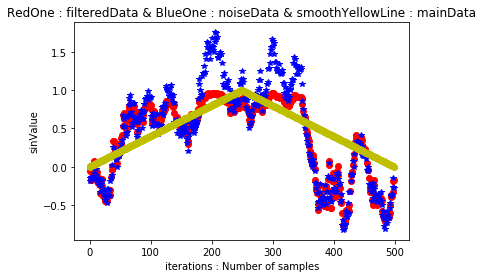

In [46]:
"""
Triangle Wave
1.Creating Noisy signal ---> now it is gaussian
2.Creating RNN and filter the noisy Data
3.plot the Graphs and enjoy the accurance of the functions ...
"""
TriangleInputData, TriangleOutputData = createDataset(100, 1, 250, 500, 'triangle', 'brownian',0,0.1)
# as TA mentioned we considered 80 percent of input as Train part and left 20 percent as test ...
TrainTriangleInp, TrainTraingleOut = TriangleInputData[:80], TriangleOutputData[:80]
TestTriangleInp, TestTriangleOut = TriangleInputData[80:], TriangleOutputData[80:]

input_dim = 1
hidden_size_net = 50
num_layers = 1

triDenoise = DenoiseRNN(input_dim, hidden_size_net, 1)

predictions = []
optimizer = torch.optim.Adam(triDenoise.parameters(), lr=6e-3)
loss_func = nn.L1Loss()

iterationNumber = 30
lossDoc = np.zeros(iterationNumber)
for t in range(iterationNumber):
    hidden = None
    inp = Variable(torch.Tensor(TriangleInputData.reshape((TriangleInputData.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(TriangleInputData.reshape((TriangleInputData.shape[0], -1, 1))) )
    
    pred = triDenoise(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    lossDoc[t] = loss
    loss.backward()
    optimizer.step()

print("losses!!!",lossDoc)       
t_inp = Variable(torch.Tensor(TriangleInputData.reshape((TriangleInputData.shape[0], -1, 1))), requires_grad=True)
pred_t = triDenoise(t_inp)

# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(TriangleOutputData.reshape((TriangleInputData.shape[0], -1, 1))))))
sample_num = 11

plt.subplot(3,1, 1)
plt.plot(pred_t[sample_num].data.numpy())
plt.title('filtered')
plt.subplot(3,1, 2)

plt.plot(t_inp[sample_num].data.numpy())
plt.title('input data & via brownian nosie added ...')
plt.subplot(3,1, 3)
plt.plot(TestTriangleOut[sample_num])
plt.title('output data')

plt.gcf().set_size_inches(18, 5)
plt.show()

# all togather ...
plt.plot(pred_t[sample_num].data.numpy(),'ro')
plt.plot(t_inp[sample_num].data.numpy(),'b*')
plt.plot(TestTriangleOut[sample_num],'yo-')

plt.title("RedOne : filteredData & BlueOne : noiseData & smoothYellowLine : mainData")
plt.xlabel("iterations : Number of samples")
plt.ylabel("sinValue")

# as you see the RedOnes are nearer to the main Data ...
# and they get closer to the yellow 
# and as you can see the noise input variance is too more than the filtered signal ...
# so our filter works properly ...

losses!!! [0.51553404 0.51553404 0.51553404 0.51553404 0.51553404 0.51553404
 0.51553404 0.51553404 0.51553404 0.51553404 0.51553404 0.51553404
 0.51553404 0.51553404 0.51553404 0.51553404 0.51553404 0.51553404
 0.51553404 0.51553404 0.51553404 0.51553404 0.51553404 0.51553404
 0.51553404 0.51553404 0.51553404 0.51553404 0.51553404 0.51553404]
tensor(0.5155, grad_fn=<L1LossBackward>)


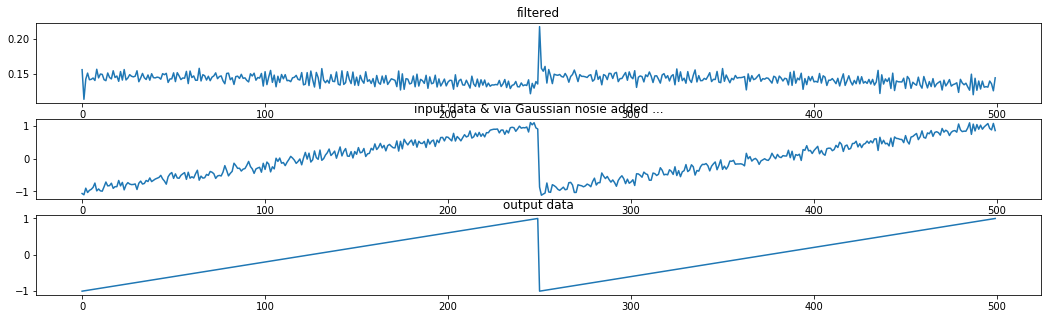

Text(0,0.5,'sinValue')

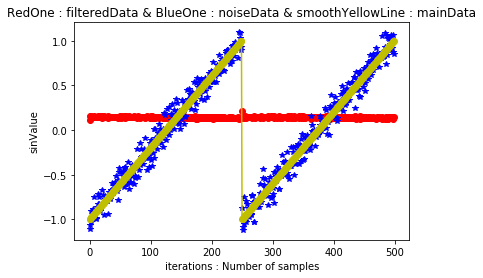

In [42]:
"""
Teeth!!! Wave
1.Creating Noisy signal --> now it is brownian
2.Creating RNN and filter the noisy Data
3.plot the Graphs and enjoy the accurance of the functions ...
"""
teethInputData, teethOutputData = createDataset(100, 1, 250, 500, 'teeth', 'brownian',0,0.1)
# as TA mentioned we considered 80 percent of input as Train part and left 20 percent as test ...
TrainTeethInp, TrainTeethOut = teethInputData[:80], teethOutputData[:80]
TestTeethInp, TestTeethOut = teethInputData[80:], teethOutputData[80:]

input_dim = 1
hidden_size_net = 50
num_layers = 1

teethDenoise = DenoiseRNN(input_dim, hidden_size_net, 1)

predictions = []
optimizer = torch.optim.Adam(sinDenoise.parameters(), lr=6e-3)
loss_func = nn.L1Loss()

iterationNumber = 30
lossDoc = np.zeros(iterationNumber)
for t in range(iterationNumber):
    
    hidden = None
    inp = Variable(torch.Tensor(teethInputData.reshape((teethInputData.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(teethOutputData.reshape((teethOutputData.shape[0], -1, 1))) )
    
    pred = teethDenoise(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    lossDoc[t] = loss
    loss.backward()
    optimizer.step()

print("losses!!!",lossDoc)   

t_inp = Variable(torch.Tensor(teethInputData.reshape((teethInputData.shape[0], -1, 1))), requires_grad=True)
pred_t = teethDenoise(t_inp)

# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(teethOutputData.reshape((teethInputData.shape[0], -1, 1))))))
sample_num = 10

plt.subplot(3, 1, 1)
plt.plot(pred_t[sample_num].data.numpy())
plt.title('filtered')
plt.subplot(3, 1, 2)

plt.plot(t_inp[sample_num].data.numpy())
plt.title('input data & via brownian nosie added ...')
plt.subplot(3, 1, 3)
plt.plot(TestTeethOut[sample_num])
plt.title('output data')

plt.gcf().set_size_inches(18, 5)
plt.show()

# all togather ...

plt.plot(pred_t[sample_num].data.numpy(),'ro')
plt.plot(t_inp[sample_num].data.numpy(),'b*')
plt.plot(TestTeethOut[sample_num],'yo-')

plt.title("RedOne : filteredData & BlueOne : noiseData & smoothYellowLine : mainData")
plt.xlabel("iterations : Number of samples")
plt.ylabel("sinValue")

# as you see the RedOnes are nearer to the main Data ...
# so our filter works properly!!!

Var_1 = 0.1 : losses!!! [0.63935012 0.26585808 0.24218555 0.19847344 0.18634537 0.1832781
 0.18557727 0.19257069 0.20107929 0.20707875 0.20846324 0.20565151
 0.20137185 0.19812863 0.19725974 0.19863267 0.20088406 0.2023744
 0.20209749 0.20022012 0.19772789 0.19584711 0.1951213  0.19520323
 0.19571392 0.19592774 0.19511841 0.1923154  0.18615504 0.17658181]
Var_2 = 0.2 : losses!!! [0.54817903 0.1405904  0.13999812 0.14436211 0.14782229 0.14787973
 0.14528787 0.14067858 0.13688219 0.1353057  0.13658701 0.14067297
 0.14615376 0.15068619 0.15201512 0.14993113 0.14634119 0.14300086
 0.14037059 0.13850909 0.13710932 0.1357373  0.13423538 0.13268663
 0.1314496  0.13106479 0.13239171 0.13701373 0.14816873 0.16785561]
Var_3 = 0.3 : losses!!! [0.43279833 0.23027869 0.21723348 0.21543123 0.21140881 0.20790403
 0.20850261 0.21144216 0.21364561 0.21357158 0.21117307 0.20741735
 0.20402445 0.20207603 0.20208922 0.20352416 0.20470357 0.20406485
 0.20134291 0.19726637 0.19294152 0.18912591 0.18585137 0

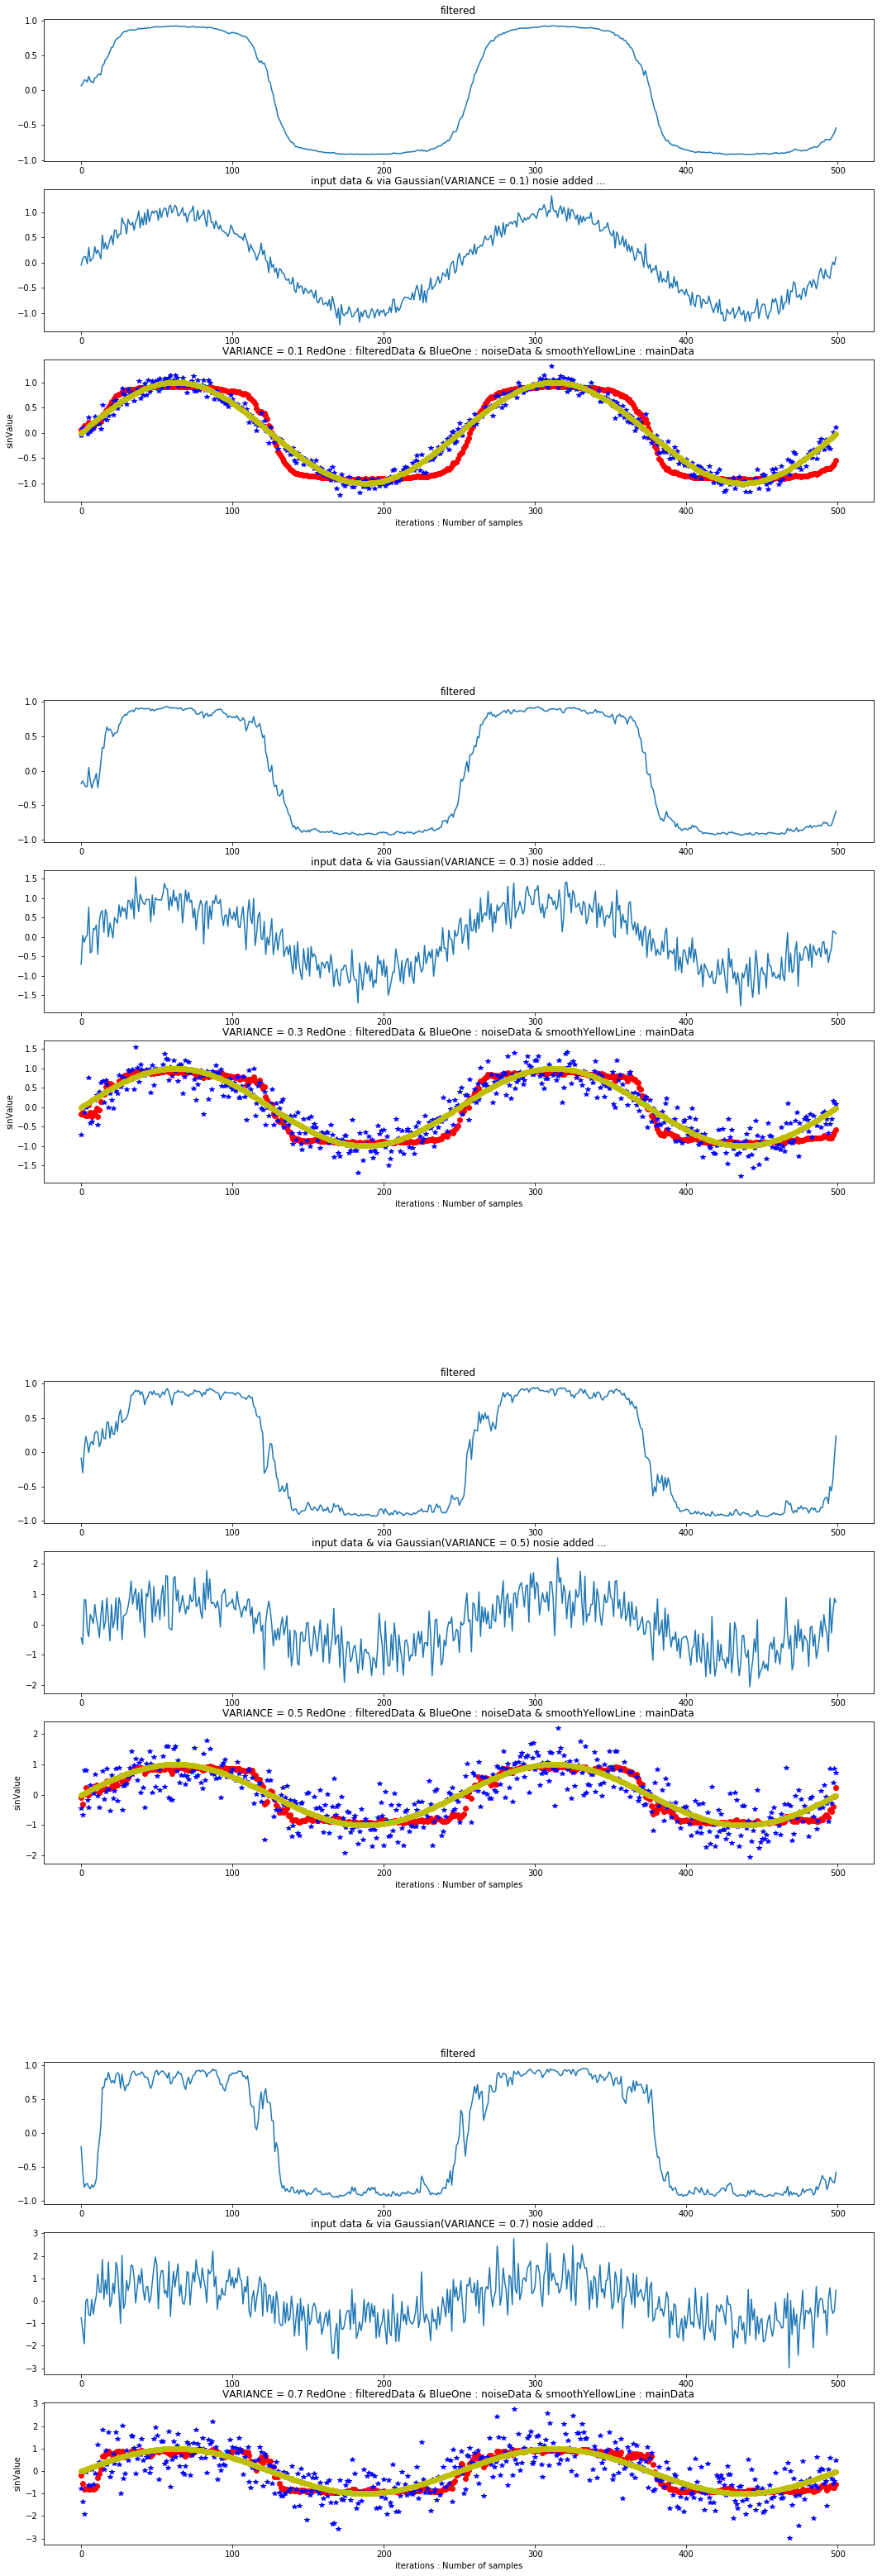

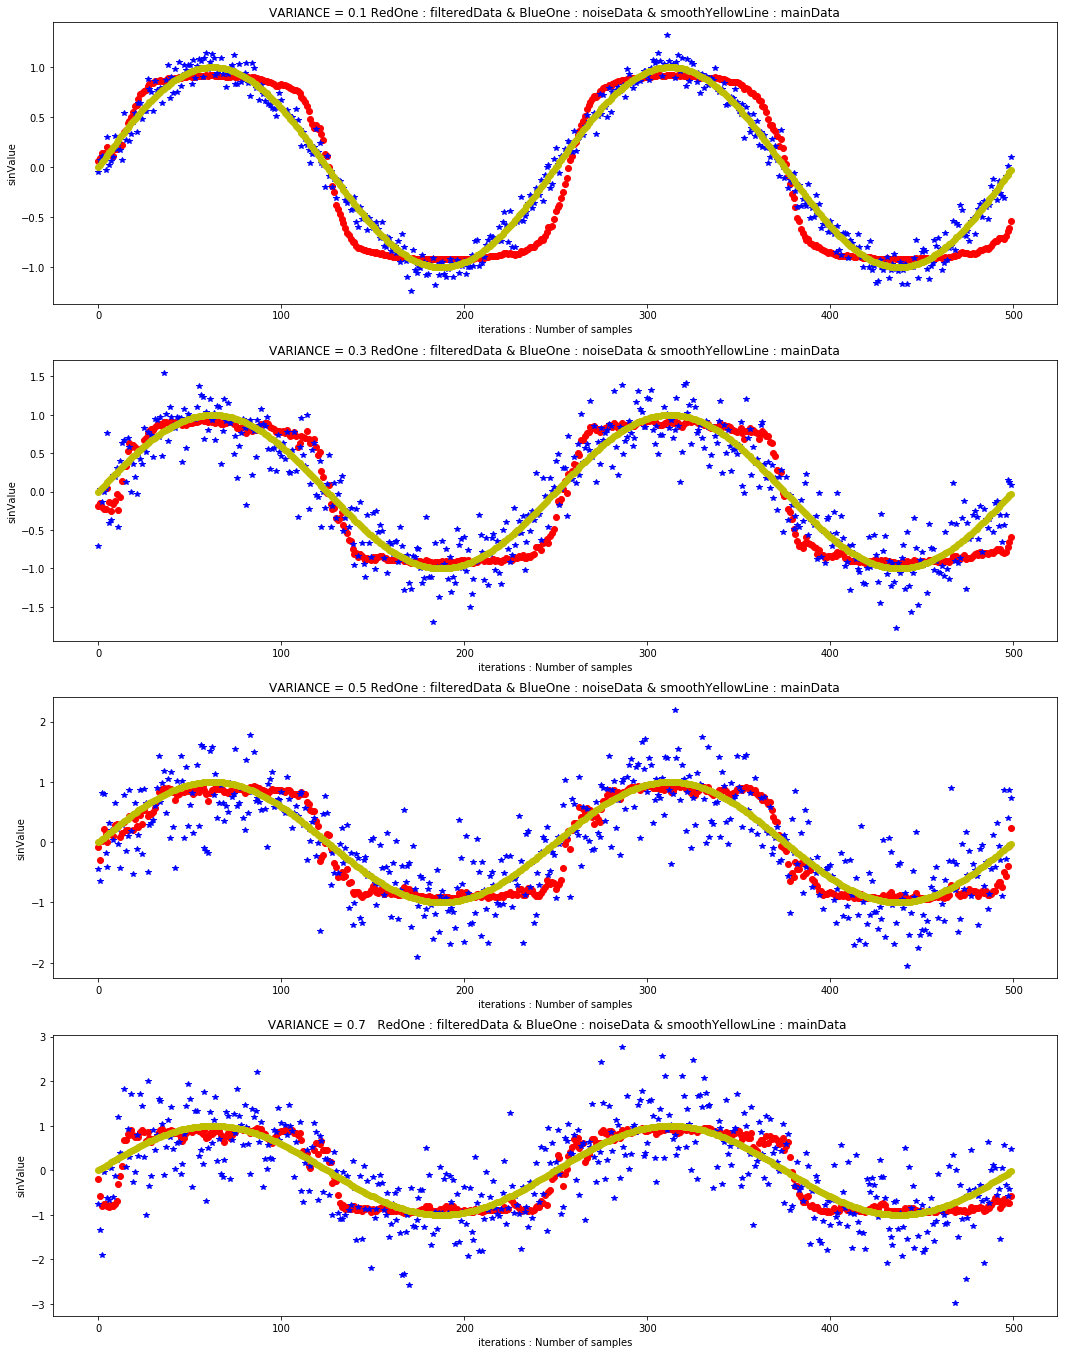

In [81]:
"""

        SNR analysis and variance effects
        normal noise via 0.1 0.3 0.5 and 0.7 NoiseVariances ...
        
"""
sinInputDataVar1, sinOutputDataVar1 = createDataset(100, 1, 250, 500, 'sin', 'n',0,0.1)
# as TA mentioned we considered 80 percent of input as Train part and left 20 percent as test ...
TrainSinInpVar1, TrainSinOutVar1 = sinInputDataVar1[:80], sinOutputDataVar1[:80]
TestSinInpVar1, TestSinOutVar1 = sinInputDataVar1[80:], sinOutputDataVar1[80:]

sinInputDataVar2, sinOutputDataVar2 = createDataset(100, 1, 250, 500, 'sin', 'n',0,0.3)
# as TA mentioned we considered 80 percent of input as Train part and left 20 percent as test ...
TrainSinInpVar2, TrainSinOutVar2 = sinInputDataVar2[:80], sinOutputDataVar2[:80]
TestSinInpVar2, TestSinOutVar2 = sinInputDataVar2[80:], sinOutputDataVar2[80:]

sinInputDataVar3, sinOutputDataVar3 = createDataset(100, 1, 250, 500, 'sin', 'n',0,0.5)
# as TA mentioned we considered 80 percent of input as Train part and left 20 percent as test ...
TrainSinInpVar3, TrainSinOutVar3 = sinInputDataVar3[:80], sinOutputDataVar3[:80]
TestSinInpVar3, TestSinOutVar3 = sinInputDataVar3[80:], sinOutputDataVar3[80:]

sinInputDataVar4, sinOutputDataVar4 = createDataset(100, 1, 250, 500, 'sin', 'n',0,0.7)
# as TA mentioned we considered 80 percent of input as Train part and left 20 percent as test ...
TrainSinInpVar4, TrainSinOutVar4 = sinInputDataVar4[:80], sinOutputDataVar4[:80]
TestSinInpVar4, TestSinOutVar4 = sinInputDataVar4[80:], sinOutputDataVar4[80:]

input_dim = 1
hidden_size_net = 50
num_layers = 1

sinDenoise = DenoiseRNN(input_dim, hidden_size_net, 1)

predictions1 = []
optimizer1 = torch.optim.Adam(sinDenoise.parameters(), lr=6e-3)
loss_func1 = nn.L1Loss()

predictions2 = []
optimizer2 = torch.optim.Adam(sinDenoise.parameters(), lr=6e-3)
loss_func2 = nn.L1Loss()

predictions3 = []
optimizer3 = torch.optim.Adam(sinDenoise.parameters(), lr=6e-3)
loss_func3 = nn.L1Loss()

predictions4 = []
optimizer4 = torch.optim.Adam(sinDenoise.parameters(), lr=6e-3)
loss_func4 = nn.L1Loss()


iterationNumber = 30
lossDoc1 = np.zeros(iterationNumber)
lossDoc2 = np.zeros(iterationNumber)
lossDoc3 = np.zeros(iterationNumber)
lossDoc4 = np.zeros(iterationNumber)

for t in range(iterationNumber):
    
    hidden = None
    inp1 = Variable(torch.Tensor(TrainSinInpVar1.reshape((TrainSinInpVar1.shape[0], -1, 1))), requires_grad=True)
    out1 = Variable(torch.Tensor(TrainSinOutVar1.reshape((TrainSinOutVar1.shape[0], -1, 1))) )
    
    inp2 = Variable(torch.Tensor(TrainSinInpVar2.reshape((TrainSinInpVar2.shape[0], -1, 1))), requires_grad=True)
    out2 = Variable(torch.Tensor(TrainSinOutVar2.reshape((TrainSinOutVar2.shape[0], -1, 1))) )
    
    inp3 = Variable(torch.Tensor(TrainSinInpVar3.reshape((TrainSinInpVar3.shape[0], -1, 1))), requires_grad=True)
    out3 = Variable(torch.Tensor(TrainSinOutVar3.reshape((TrainSinOutVar3.shape[0], -1, 1))) )
    
    inp4 = Variable(torch.Tensor(TrainSinInpVar4.reshape((TrainSinInpVar4.shape[0], -1, 1))), requires_grad=True)
    out4 = Variable(torch.Tensor(TrainSinOutVar4.reshape((TrainSinOutVar4.shape[0], -1, 1))) )
    
       
    pred1 = sinDenoise(inp1)
    optimizer1.zero_grad()
    predictions1.append(pred1.data.numpy())
    loss1 = loss_func(pred1, out1)
    lossDoc1[t] = loss1
    loss1.backward()
    optimizer1.step()
    
    
    pred2 = sinDenoise(inp2)
    optimizer2.zero_grad()
    predictions2.append(pred2.data.numpy())
    loss2 = loss_func(pred2, out2)
    lossDoc2[t] = loss2
    loss2.backward()
    optimizer2.step()
    
    
    pred3 = sinDenoise(inp3)
    optimizer3.zero_grad()
    predictions3.append(pred3.data.numpy())
    loss3 = loss_func(pred3, out3)
    lossDoc3[t] = loss3
    loss3.backward()
    optimizer3.step()
    
    
    pred4 = sinDenoise(inp4)
    optimizer4.zero_grad()
    predictions4.append(pred4.data.numpy())
    loss4 = loss_func(pred4, out4)
    lossDoc4[t] = loss4
    loss4.backward()
    optimizer4.step()
    

print("Var_1 = 0.1 : losses!!!",lossDoc1)   
print("Var_2 = 0.2 : losses!!!",lossDoc2)   
print("Var_3 = 0.3 : losses!!!",lossDoc3)   
print("Var_4 = 0.4 : losses!!!",lossDoc4) 


t_inp1 = Variable(torch.Tensor(TestSinInpVar1.reshape((TestSinInpVar1.shape[0], -1, 1))), requires_grad=True)
pred_t1 = sinDenoise(t_inp1)

t_inp2 = Variable(torch.Tensor(TestSinInpVar2.reshape((TestSinInpVar2.shape[0], -1, 1))), requires_grad=True)
pred_t2 = sinDenoise(t_inp2)

t_inp3 = Variable(torch.Tensor(TestSinInpVar3.reshape((TestSinInpVar3.shape[0], -1, 1))), requires_grad=True)
pred_t3 = sinDenoise(t_inp3)

t_inp4 = Variable(torch.Tensor(TestSinInpVar4.reshape((TestSinInpVar4.shape[0], -1, 1))), requires_grad=True)
pred_t4 = sinDenoise(t_inp4)


# Test loss
print(loss_func(pred_t1, Variable(torch.Tensor(TestSinOutVar1.reshape((TestSinInpVar1.shape[0], -1, 1))))))
sample_num1 = 10

# Test loss
print(loss_func(pred_t2, Variable(torch.Tensor(TestSinOutVar2.reshape((TestSinInpVar2.shape[0], -1, 1))))))
sample_num2 = 10

# Test loss
print(loss_func(pred_t3, Variable(torch.Tensor(TestSinOutVar3.reshape((TestSinInpVar3.shape[0], -1, 1))))))
sample_num3 = 10

# Test loss
print(loss_func(pred_t4, Variable(torch.Tensor(TestSinOutVar4.reshape((TestSinInpVar4.shape[0], -1, 1))))))
sample_num4 = 10




plt.subplot(16, 1, 1)
plt.plot(pred_t1[sample_num1].data.numpy())
plt.title('filtered')
plt.subplot(16, 1, 2)

plt.plot(t_inp1[sample_num1].data.numpy())
plt.title('input data & via Gaussian(VARIANCE = 0.1) nosie added ...')
plt.subplot(16, 1, 3)
plt.plot(TestSinOutVar1[sample_num1])
plt.title('output data')


# all togather ...

plt.plot(pred_t1[sample_num1].data.numpy(),'ro')
plt.plot(t_inp1[sample_num1].data.numpy(),'b*')
plt.plot(TestSinOutVar1[sample_num1],'yo-')

plt.title("VARIANCE = 0.1 RedOne : filteredData & BlueOne : noiseData & smoothYellowLine : mainData")
plt.xlabel("iterations : Number of samples")
plt.ylabel("sinValue")

# as you see the RedOnes are nearer to the main Data ...
# so our filter works properly!!!

plt.subplot(16, 1, 5)
plt.plot(pred_t2[sample_num2].data.numpy())
plt.title('filtered')
plt.subplot(16, 1, 6)

plt.plot(t_inp2[sample_num2].data.numpy())
plt.title('input data & via Gaussian(VARIANCE = 0.3) nosie added ...')
plt.subplot(16, 1, 7)
plt.plot(TestSinOutVar2[sample_num2])
plt.title('output data')


# all togather ...

plt.plot(pred_t2[sample_num2].data.numpy(),'ro')
plt.plot(t_inp2[sample_num2].data.numpy(),'b*')
plt.plot(TestSinOutVar2[sample_num2],'yo-')

plt.title("VARIANCE = 0.3 RedOne : filteredData & BlueOne : noiseData & smoothYellowLine : mainData")
plt.xlabel("iterations : Number of samples")
plt.ylabel("sinValue")

# as you see the RedOnes are nearer to the main Data ...
# so our filter works properly!!!

plt.subplot(16, 1, 9)
plt.plot(pred_t3[sample_num3].data.numpy())
plt.title('filtered')
plt.subplot(16, 1, 10)

plt.plot(t_inp3[sample_num3].data.numpy())
plt.title('input data & via Gaussian(VARIANCE = 0.5) nosie added ...')
plt.subplot(16, 1, 11)
plt.plot(TestSinOutVar3[sample_num3])
plt.title('output data')


# all togather ...

plt.plot(pred_t3[sample_num3].data.numpy(),'ro')
plt.plot(t_inp3[sample_num3].data.numpy(),'b*')
plt.plot(TestSinOutVar3[sample_num3],'yo-')

plt.title("VARIANCE = 0.5 RedOne : filteredData & BlueOne : noiseData & smoothYellowLine : mainData")
plt.xlabel("iterations : Number of samples")
plt.ylabel("sinValue")

# as you see the RedOnes are nearer to the main Data ...
# so our filter works properly!!!



plt.subplot(16, 1, 13)
plt.plot(pred_t4[sample_num4].data.numpy())
plt.title('filtered')
plt.subplot(16, 1, 14)

plt.plot(t_inp4[sample_num4].data.numpy())
plt.title('input data & via Gaussian(VARIANCE = 0.7) nosie added ...')
plt.subplot(16, 1, 15)
plt.plot(TestSinOutVar4[sample_num4])
plt.title('output data')

# all togather ...

plt.plot(pred_t4[sample_num4].data.numpy(),'ro')
plt.plot(t_inp4[sample_num4].data.numpy(),'b*')
plt.plot(TestSinOutVar4[sample_num4],'yo-')

plt.title("VARIANCE = 0.7 RedOne : filteredData & BlueOne : noiseData & smoothYellowLine : mainData")
plt.xlabel("iterations : Number of samples")
plt.ylabel("sinValue")

plt.gcf().set_size_inches(18, 60)
plt.show()


plt.subplot(5,1,2)

plt.plot(pred_t1[sample_num1].data.numpy(),'ro')
plt.plot(t_inp1[sample_num1].data.numpy(),'b*')
plt.plot(TestSinOutVar1[sample_num1],'yo-')

plt.title("VARIANCE = 0.1 RedOne : filteredData & BlueOne : noiseData & smoothYellowLine : mainData")
plt.xlabel("iterations : Number of samples")
plt.ylabel("sinValue")

# as you see the RedOnes are nearer to the main Data ...
# so our filter works properly!!!

plt.subplot(5,1,3)

# all togather ...

plt.plot(pred_t2[sample_num2].data.numpy(),'ro')
plt.plot(t_inp2[sample_num2].data.numpy(),'b*')
plt.plot(TestSinOutVar2[sample_num2],'yo-')

plt.title("VARIANCE = 0.3 RedOne : filteredData & BlueOne : noiseData & smoothYellowLine : mainData")
plt.xlabel("iterations : Number of samples")
plt.ylabel("sinValue")

# as you see the RedOnes are nearer to the main Data ...
# so our filter works properly!!!

plt.subplot(5,1,4)

# all togather ...

plt.plot(pred_t3[sample_num3].data.numpy(),'ro')
plt.plot(t_inp3[sample_num3].data.numpy(),'b*')
plt.plot(TestSinOutVar3[sample_num3],'yo-')

plt.title("VARIANCE = 0.5 RedOne : filteredData & BlueOne : noiseData & smoothYellowLine : mainData")
plt.xlabel("iterations : Number of samples")
plt.ylabel("sinValue")

# as you see the RedOnes are nearer to the main Data ...
# so our filter works properly!!!

plt.subplot(5,1,5)

# all togather ...

plt.plot(pred_t4[sample_num4].data.numpy(),'ro')
plt.plot(t_inp4[sample_num4].data.numpy(),'b*')
plt.plot(TestSinOutVar4[sample_num4],'yo-')

plt.title(" VARIANCE = 0.7   RedOne : filteredData & BlueOne : noiseData & smoothYellowLine : mainData")
plt.xlabel("iterations : Number of samples")
plt.ylabel("sinValue")

plt.gcf().set_size_inches(18, 30)
plt.show()

# as you see as the variance increases the noise easily being detected and also catched!!!
# last Graph shows this fact intensively 
